In [86]:
%matplotlib inline
import numpy as np
from numpy import mean
from numpy import std
from numpy import dstack
import pandas as pd
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras.layers import Flatten, LSTM
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

In [57]:
#load data
from BIAS.SB_Test_runner import get_scens_per_dim, get_simulated_data

rep = 1000
n_samples = 100

scenes = get_scens_per_dim()
X = []
y = []
for scene in scenes:
    label = scene[0]
    kwargs = scene[1]
    if (label == "unif"):
        rep1 = 10 * rep
    else:
        rep1 = rep
    data = get_simulated_data(label, rep=rep1, n_samples = n_samples, kwargs=kwargs)
    for r in range(rep):
        X.append(np.sort(data[:,r]))
    y.extend([label]*rep)

X = np.array(X)
int_y = pd.factorize(y)[0]
targetnames = np.unique(y)

cat_y = to_categorical(int_y)

In [96]:
# fit and evaluate a model
def evaluate_model(trainX, trainy):
	verbose, epochs, batch_size = 1, 100, 200
	n_features, n_outputs = 100, trainy.shape[1]
	model = Sequential()
	model.add(LSTM(128, input_shape=(1, n_features)))
	#model.add(Dense(640, activation='relu', input_shape=(n_features,)))
	#model.add(Dropout(0.3))
	#model.add(Dense(320, activation='relu'))
	#model.add(Dropout(0.3))
	#model.add(BatchNormalization())
	model.add(Dense(n_outputs, activation='softmax'))
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	model.summary()

	es_callback = EarlyStopping(monitor='val_loss', patience=10)
	# fit network
	history = model.fit(trainX, trainy, validation_split=0.1, epochs=epochs, batch_size=batch_size, verbose=verbose, callbacks=[es_callback])
	plt.plot(history.history['accuracy'])
	plt.plot(history.history['val_accuracy'])
	plt.title('model accuracy')
	plt.ylabel('accuracy')
	plt.xlabel('epoch')
	plt.legend(['train', 'test'], loc='upper left')
	plt.show()
	plt.clf()
	# summarize history for loss
	plt.plot(history.history['loss'])
	plt.plot(history.history['val_loss'])
	plt.title('model loss')
	plt.ylabel('loss')
	plt.xlabel('epoch')
	plt.legend(['train', 'test'], loc='upper left')
	plt.show()
	plt.clf()
	# evaluate model
	#_, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
	return model

# summarize scores
def summarize_results(scores):
	print(scores)
	m, s = mean(scores), std(scores)
	print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

In [59]:
print(X.shape, cat_y.shape, int_y.shape)

(194000, 100) (194000, 11) (194000,)


In [82]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.neural_network import MLPClassifier
class newmodel(MLPClassifier):
    def __init__(self, model):
        self.model = model
    def predict(self, X):
        y = self.model.predict(X)
        return np.argmax(y, axis=1)



In [ ]:
X_reshape = X.reshape(X.shape[0], 1, X.shape[1])

(194000, 1, 100)
Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_58 (Dense)             (None, 11)                1419      
Total params: 118,667
Trainable params: 118,667
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
873/873 [==============================] - 4s 3ms/step - loss: 1.6534 - accuracy: 0.4184 - val_loss: 6.7449 - val_accuracy: 0.1000
Epoch 2/100
873/873 [==============================] - 2s 3ms/step - loss: 1.2647 - accuracy: 0.5392 - val_loss: 7.3257 - val_accuracy: 0.1768
Epoch 3/100
873/873 [==============================] - 2s 3ms/step - loss: 1.2051 - accuracy: 0.5583 - val_loss: 8.0746 - val_accuracy: 0.1502
Epoch 4/100
873/873 [==============================] - 3s 3ms/s

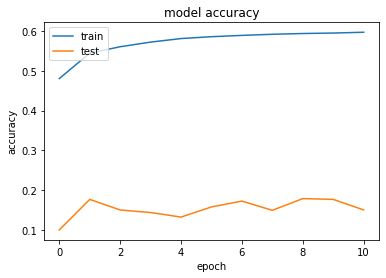

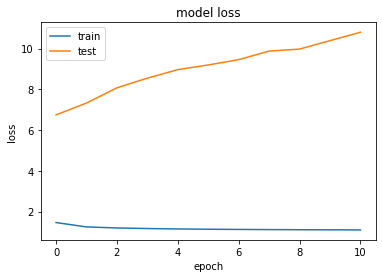

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [98]:
#CV
#from sklearn.model_selection import StratifiedKFold

#scores = []
#skf = StratifiedKFold(n_splits=2)
#or train_index, test_index in skf.split(X, int_y):
#    X_train, X_test = X[train_index,:], X[test_index,:]
#    y_train, y_test = cat_y[train_index,:], cat_y[test_index,:]
#    model, score = evaluate_model(X_train, y_train, X_test, y_test)
#    scores.append(score)
#    
#    model1 = newmodel(model)
#    plot_confusion_matrix(model1, X_test, np.argmax(y_test, axis=1), normalize='true', xticks_rotation = 'vertical', display_labels = list(np.unique(targetnames))) 
#    plt.clf()

model = evaluate_model(X_reshape, cat_y)
model1 = newmodel(model)

plot_confusion_matrix(model1, X_reshape, np.argmax(cat_y, axis=1), normalize='true', xticks_rotation = 'vertical', display_labels = list(np.unique(targetnames))) 
plt.clf()

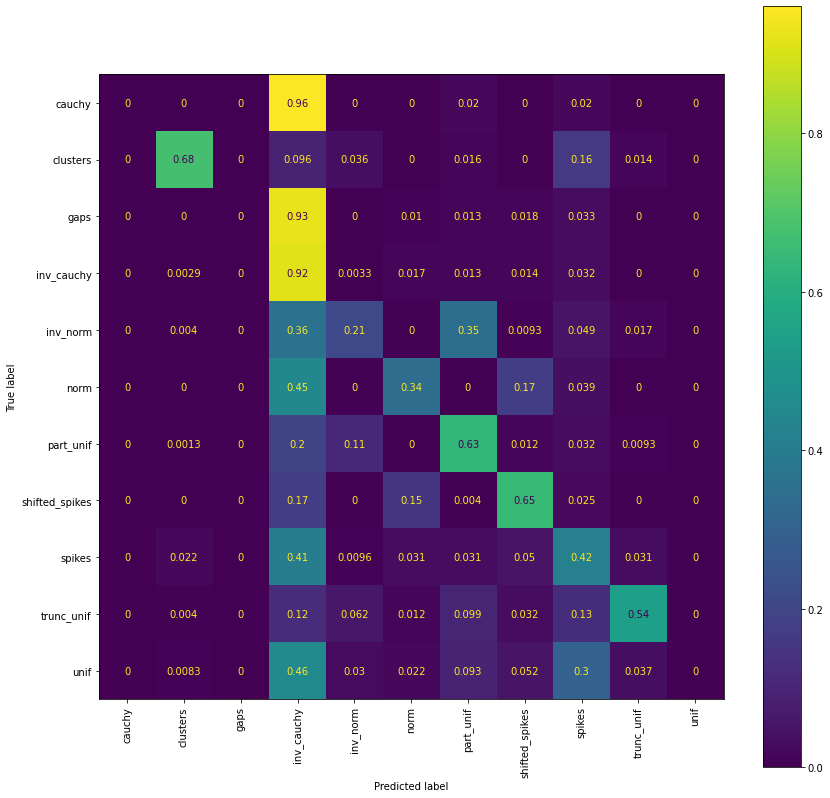

In [62]:
model1 = newmodel(model)
fig, ax = plt.subplots(figsize=(14, 14))
plot_confusion_matrix(model1, X_test, np.argmax(y_test, axis=1), normalize='true', xticks_rotation = 'vertical', display_labels = list(np.unique(targetnames)), ax=ax) 
plt.show()

In [72]:
np.argmax(y_test, axis=1)

array([ 0,  0,  0, ..., 10, 10, 10], dtype=int64)

In [76]:

y_pred = model.predict(X_test)
y_pred[0]
np.argmax(y_pred, axis=1)

array([3, 3, 3, ..., 3, 3, 3], dtype=int64)

In [65]:
y_test.shape

(9700, 11)